In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvregularized import TVRegularized
from bimpcc.models.tvdenoising_model import TVDenoisingMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [6]:
scale = 16

In [7]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(15.5), np.float64(15.5), np.float64(-0.5))

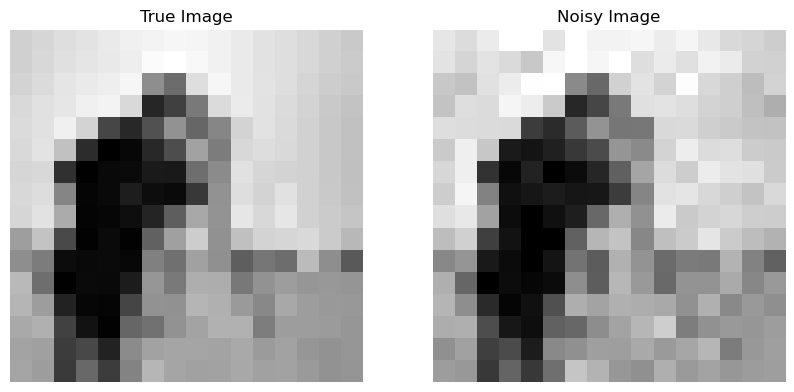

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [9]:
model = TVRegularized(true, noisy, epsilon=1e-3)

In [10]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)

In [11]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

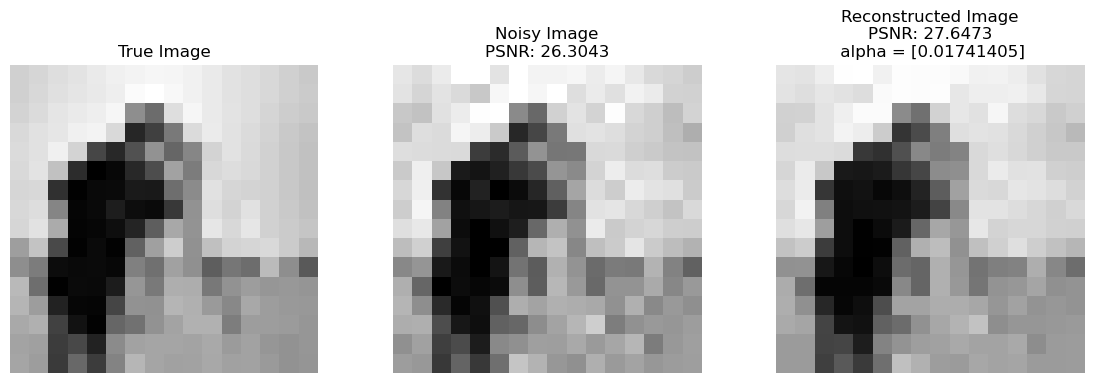

In [12]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [13]:
m = q.flatten().size
n = m // 2
Ku = model.K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ
# theta0 = np.zeros(n)

In [14]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10  

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [15]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))
print(x0_mpcc)

[ 0.87801868  0.87365001  0.91139987 ...  0.54213705 -0.08090701
  0.01741405]


In [16]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=1e-3)

In [17]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-4,print_level=5,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

0                 1  0.07120841073116528     3.4317832960853525                 1.0

1                 1  0.07124346998059479     3.4030546932462395                 0.5

2                 1  0.07124346989400507     2.6417540081652002                0.25

3                 1  0.07195659245608121     1.6682094833308512               0.125

4                 1  0.07594728594926706     1.056602638076643               0.0625

5                 1  0.08587113911103605     0.6913690672065247             0.03125

6                 1  0.10143824886794865     0.47938838329853056           0.015625

7                 1  0.12398059216500576     0.31961796285841926          0.0078125

8                 1  0.14805754458263984     0.2192629884347313          0.00390625

9                 1  0.17004937645114734     0.15037872561207463        0.001953125

10                 0  0.18809457112091443     0.10140976096279689       0.0009765625

11                 0  0.20128854364345414     0.0678613542464342       0.00048828125

12                 0  0.2093626986361126      0.04476398371445107     0.000244140625

13                 0  0.21403465561611312     0.029206776875872722    0.0001220703125

14                 0  0.2167073317985876      0.018892088629386006    6.103515625e-05

15                 0  0.21820728835861822     0.012091197044359292    3.0517578125e-05

16                 0  0.2190424019893298      0.007487688348901622    1.52587890625e-05

Intermediate result:  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the 
convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 0.2190424019893298
       x: [ 8.779e-01  8.736e-01 ... -3.381e-02  1.750e-02]
     nit: 25
    info:     status: 0
                   x: [ 8.779e-01  8.736e-01 ... -3.381e-02  1.750e-02]
                   g: [-9.488e-09 -9.431e-09 ... -5.721e-14  2.293e-13]
             obj_val: 0.2190424019893298
              mult_g: [-1.953e-02 -1.756e-02 ...  3.592e-03  5.384e-04]
            mult_x_L: [ 1.139e-11  1.145e-11 ...  0.000e+00  5.715e-10]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence 
tolerances (can be specified by options).'
    nfev: 26
    njev: 27

Intermediate fn: 0.2190424019893298

complementarity: 0.007487688348901622

* (STOPPED) Iteration 18: Solving the NLP problem for t = 1e-05 with complementarity: 0.007487688348901622

In [18]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

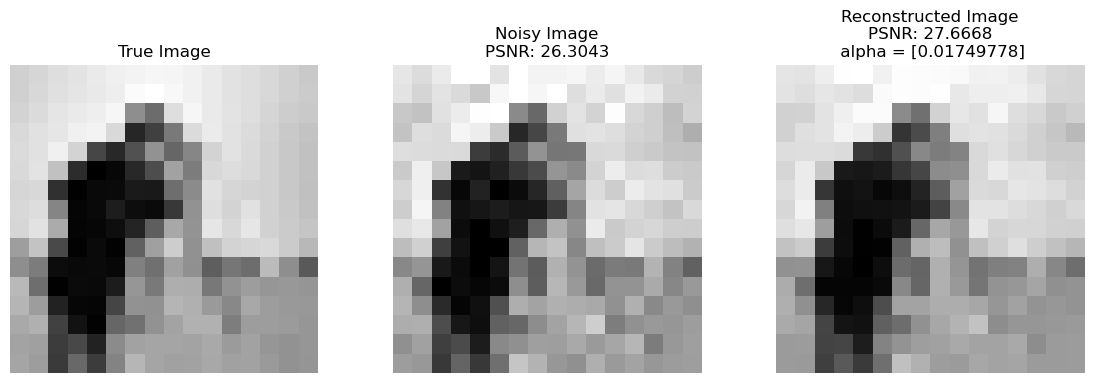

In [19]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc,alpha_mpcc)